# Lab Assignment 2 
## Signature
-----
Alexandre Dufresne-Nappert

20948586

## Tasks
-----

 1. Antiferromagnetic case (J = –1) — Reproduce Figure 10.2 for an antiferromagnet and compare with the
 ferromagnetic case.

 2. Equilibrium analysis — Test if 2000 sweeps are sufficient to reach equilibrium by plotting energy and
 magnetization vs. sweep number at several temperatures.
 
 3. External magnetic field — Modify the model to include a field term (with $g\cdot \mu_B\cdot H = 1$) and study its impact
 on energy, magnetization, heat capacity, and susceptibility.

## Deliverables
-----
Submit a Jupyter Notebook that includes:
- Code (based on Listing 10.1)
- Plots and numerical analysis for each task
- Short discussion of results and physical interpretation


# Imports
-----

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, randint, permutation
from numba import njit


# Function Definitions (From Code Provided)
----
## Notes
-----
I've reorganized the code so that functions are defined at the beginning, I've also optimized the code by having variables passed through by reference instead of using global accesses. 

Most importantly I added the Numba package to make the code compile to C using JIT compilation (Just In Time compilation) so that the code can run a lot faster

In [33]:
# Function to change indexes to subscripts ---------------------------------
@njit
def ind2sub(indx, L):
    column = np.floor(indx / L)
    row = indx - column * L
    return row, column

# Metropolis algorithm function --------------------------------------------
@njit
def Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J):
    Energy = 0.0
    for counter in range(N):  # for every spin site
        r = int(rowsub[counter])

        lo = r - 1
        if lo < 0:
            lo = L - 1

        hi = r + 1
        if hi > L - 1:
            hi = 0

        c = int(colsub[counter])

        lf = c - 1
        if lf < 0:
            lf = L - 1

        rt = c + 1
        if rt > L - 1:
            rt = 0

        # Sum neighbouring spins
        SS = Spins[lo, c] + Spins[hi, c] + Spins[r, lf] + Spins[r, rt]
        # Energy change if flipped
        DeltaE = 2 * J * SS * Spins[r, c]
        # Metropolis
        if DeltaE < 0 or rand() < np.exp(-DeltaE / T):
            Spins[r, c] = -Spins[r, c]
        if trial >= eqbmstart:
            Energy = Energy - 0.5 * J * SS * Spins[r, c]
    return Energy

@njit
def RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T, L, J):
    M = np.zeros(neq)
    E = np.zeros(neq)

    # Perform Monte-Carlo trials -----------------------------------------------
    for trial in range(trials):
        indx = permutation(N)
        rowsub, colsub = ind2sub(indx, L)
        Energy = Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J)
        if trial >= eqbmstart:
            t = trial - eqbmstart
            E[t] = Energy
            M[t] = np.sum(Spins)
            
    # Results -------------------------------------------------------------------
    Eav = np.mean(E) / N
    Cv = (np.var(E) / T**2) / N
    Mav = np.mean(M) / N
    Chi = (np.var(M) / T) / N
    
    return [Eav, Cv, Mav, Chi]
        

# Plotting Function Definitions
-----


In [34]:
def plotIsingResults(Data, T, title):
    """
    Plot Ising model results (Energy, Specific Heat, Magnetisation, Susceptibility)
    in a 2x2 grid like Figure 10.2.
    Data columns:
        0 - Energy
        1 - Specific Heat
        2 - Magnetisation
        3 - Susceptibility
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.subplots_adjust(hspace=0.35, wspace=0.25)

    # Energy
    axs[0, 0].plot(T, Data[:, 0], 'r--o', linewidth=1.2, markersize=4)
    axs[0, 0].set_xlabel("Temperature")
    axs[0, 0].set_ylabel("Energy")
    axs[0, 0].grid(True)

    # Specific heat
    axs[0, 1].plot(T, Data[:, 1], 'g--o', linewidth=1.2, markersize=4)
    axs[0, 1].set_xlabel("Temperature")
    axs[0, 1].set_ylabel("Specific heat")
    axs[0, 1].grid(True)

    # Magnetisation
    axs[1, 0].plot(T, Data[:, 2], 'b--o', linewidth=1.2, markersize=4)
    axs[1, 0].set_xlabel("Temperature")
    axs[1, 0].set_ylabel("Magnetisation")
    axs[1, 0].grid(True)

    # Susceptibility
    axs[1, 1].plot(T, Data[:, 3], 'm--o', linewidth=1.2, markersize=4)
    axs[1, 1].set_xlabel("Temperature")
    axs[1, 1].set_ylabel("Susceptibility")
    axs[1, 1].grid(True)
    
    fig.suptitle(title, fontsize=18, fontweight='bold')

    plt.show()

def plotEquilibriumAnalysis(Data, equilibriation, title):
    
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    fig.subplots_adjust(hspace=0.35, wspace=0.25)
    
    # Energy
    axs[0].plot(equilibriation, Data[:, 0], 'r--o', linewidth=1.2, markersize=4)
    axs[0].set_xlabel("Equilibriation Steps")
    axs[0].set_ylabel("Energy")
    axs[0].grid(True)

    # Magnetisation
    axs[1].plot(equilibriation, Data[:, 2], 'b--o', linewidth=1.2, markersize=4)
    axs[1].set_xlabel("Temperature")
    axs[1].set_ylabel("Equilibriation Steps")
    axs[1].grid(True)
    
    fig.suptitle(title, fontsize=18, fontweight='bold')

    plt.show()
    
    

# Global Number Variables
------

In [35]:
# Define Number of Points and How many subsims to Average for that point
Points = 11
Averaging = 3

# Question 1 : Antiferromagnetic Simulation
-----
Reproduce the equivalent of Figure 10.2 from the PDF for an antiferromagnetic system ($J=-1$).
Requirements:
- Modify the sign of $J$ in the provided code.
- Run simulations for several temperatures $T$.
- Plot average magnetization $\langle M \rangle$ and energy $\langle E \rangle$ vs. $T$ .
- Compare behavior to the ferromagnetic case ($J=+1$).

In [36]:
def RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, L, J, title):
    # Indexes : 0 : Energy, 1 : Specific Heat Capacity, 2 : Magnetisation, 3 : Spin Susceptiability
    Data = np.empty((Points, 4), dtype=float)

    # Loop through all the Points
    for i in range(Points):
        avgData = np.empty((Averaging, 4), dtype=float)

        # Loop through the number of times to average this location
        for j in range(Averaging):
            Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
            avgData[j] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[i], L, J)

        Data[i] = avgData.mean(axis=0)
    
    plotIsingResults(Data, T, title)

# Define the Magnetic Info and Temperature
SpinSites = 100
N = SpinSites**2  
T = np.linspace(1, 4, Points)  # Temperature

# Simulation Runtime
eqbmstart = 2000  
neq = 1000  
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
J = -1
#RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Antiferromagnetic (J = -1) Energies, Heat Capacity, Magnetisation and Magnetic Susceptability")

# Run Ferromagnetic Simulation
J = 1
#RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Ferromagnetic (J = 1) Energies, Heat Capacity, Magnetisation and Magnetic Susceptability")

# Question 2 : Equilibrium Analysis
-----
Investigate whether 2000 sweeps are sufficient to reach equilibrium.
 Steps:
 1. Choose temperatures below, near, and above the phase transition (e.g. $T=1.5, 2.3, 3.0$).
 2. Track energy and magnetization as functions of the number of sweeps.
 3. Plot $E$ and $M$ vs. sweeps to see when the system stabilizes.
 4. Comment on whether 2000 sweeps are sufficient



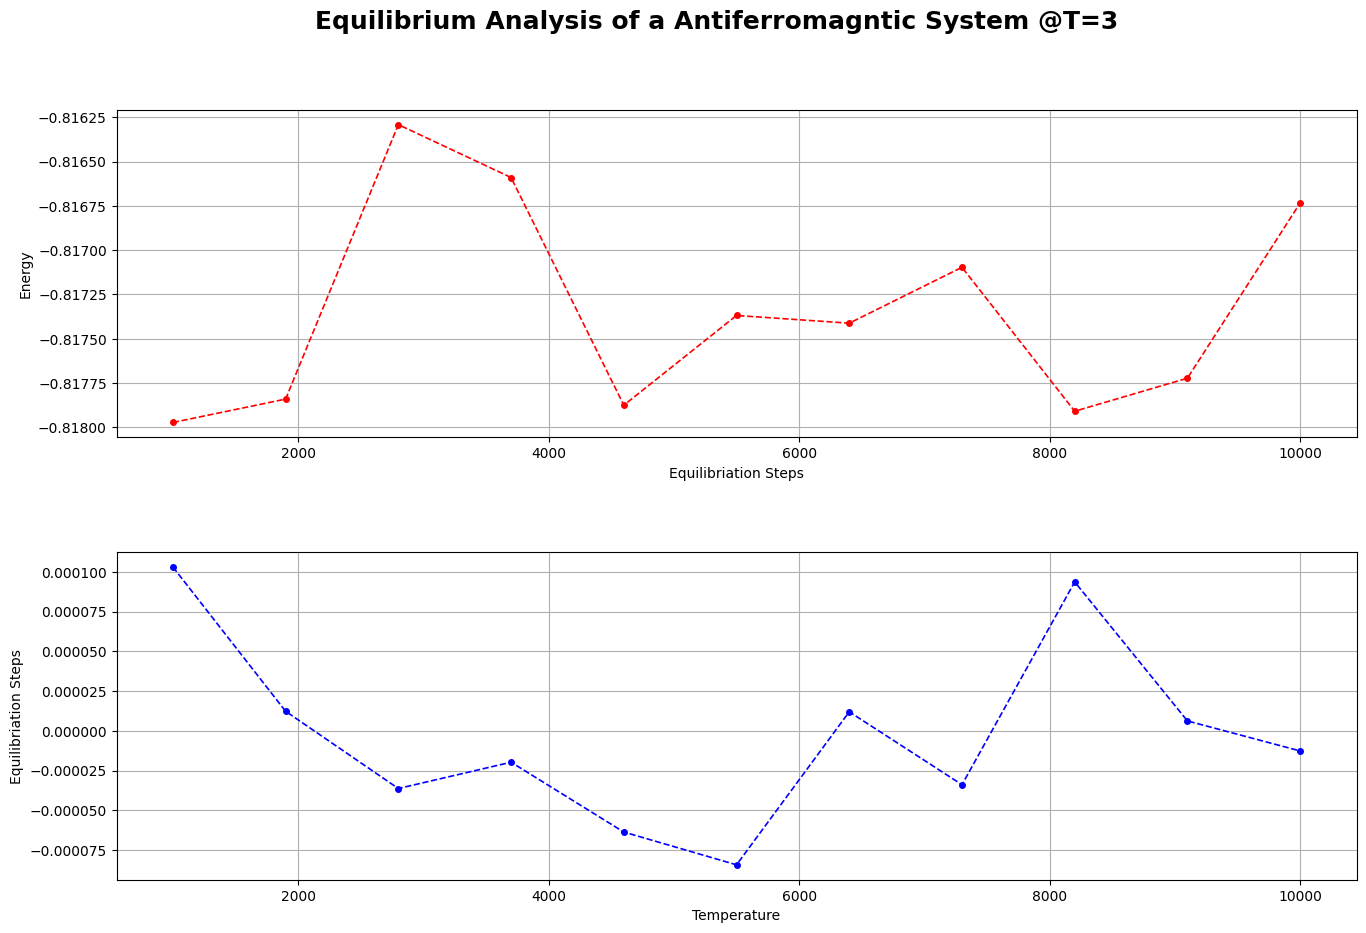

In [ ]:
def RunEquilibriumSim(Points, Averaging, eqbmstart, neq, trials, N, T, L, J, title):
    # Indexes : 0 : Energy, 1 : Specific Heat Capacity, 2 : Magnetisation, 3 : Spin Susceptiability
    Data = np.empty((Points, 4), dtype=float)

    # Loop through all the Points
    for i in range(Points):
        avgData = np.empty((Averaging, 4), dtype=float)

        # Loop through the number of times to average this location
        for j in range(Averaging):
            Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
            avgData[j] = RunMonteCarloTrials(Spins, eqbmstart[i], neq, trials[i], N, T, L, J)

        Data[i] = avgData.mean(axis=0)
    
    plotEquilibriumAnalysis(Data, eqbmstart, title)

# Define the Magnetic Info and Temperature
SpinSites = 100
N = SpinSites**2  
T = 1

# Simulation Runtime
eqbmstart = np.linspace(1000, 5000, Points, dtype=int)  
neq = 1000  
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
J = -1
RunEquilibriumSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Equilibrium Analysis of a Antiferromagntic System @T=3")

# Run Ferromagnetic Simulation
J = 1
RunEquilibriumSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Equilibrium Analysis of a Ferromagntic System @T=3")

# Question 3 : External Magnetic Field 
-----
Modify the provided code to include a magnetic field term:

$$E=-J\sum_{\langle i, j \rangle} s_i\cdot s_j - g\cdot \mu_B\cdot H \sum_i s_i$$

With $g\cdot \mu_B\cdot H = 1$

Tasks:
- Implement this in your code.
- Run simulations at various temperatures.
- Compute and plot:
    - Energy 
    - Magnetization 
    - Heat capacity 
    - Susceptibility 
- Compare with the zero-field case and discuss the effect of .